The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


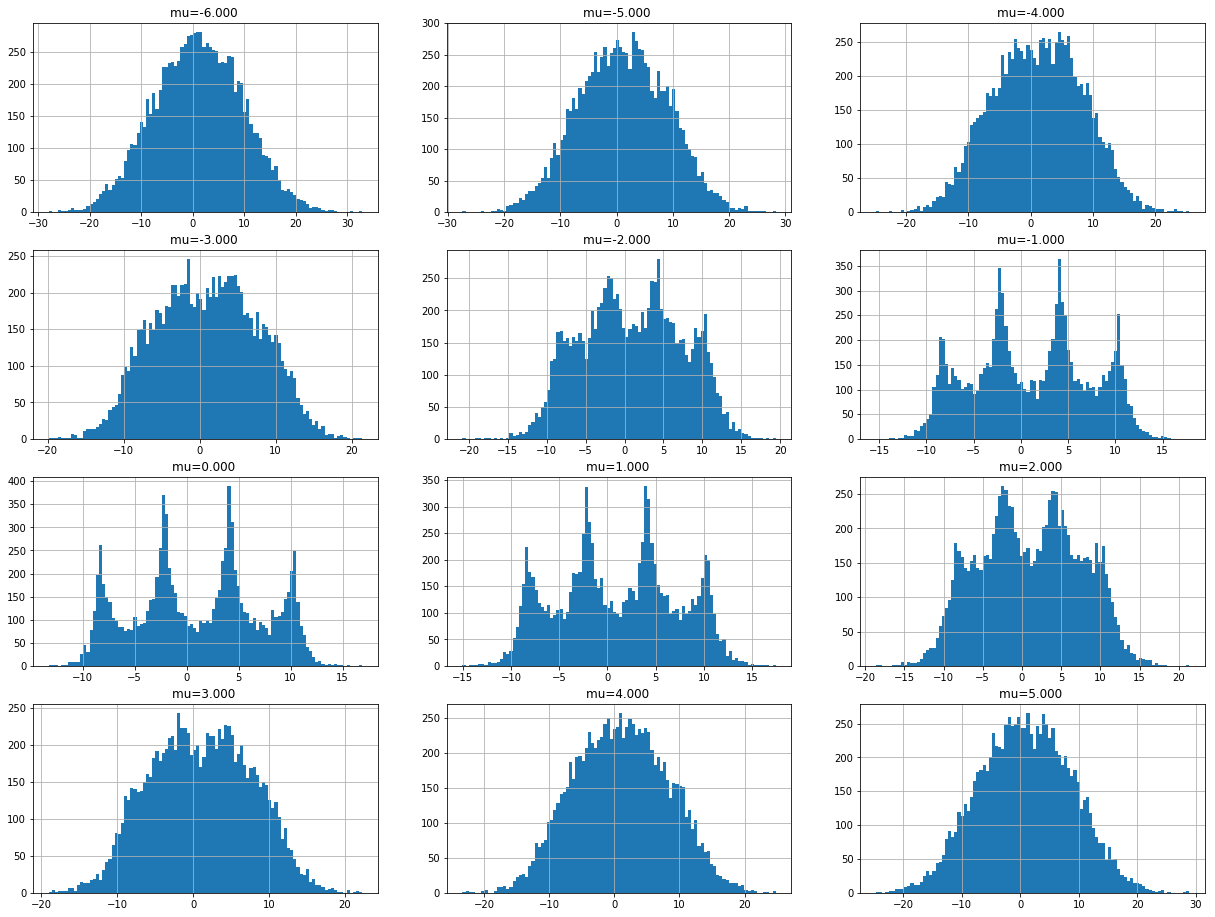

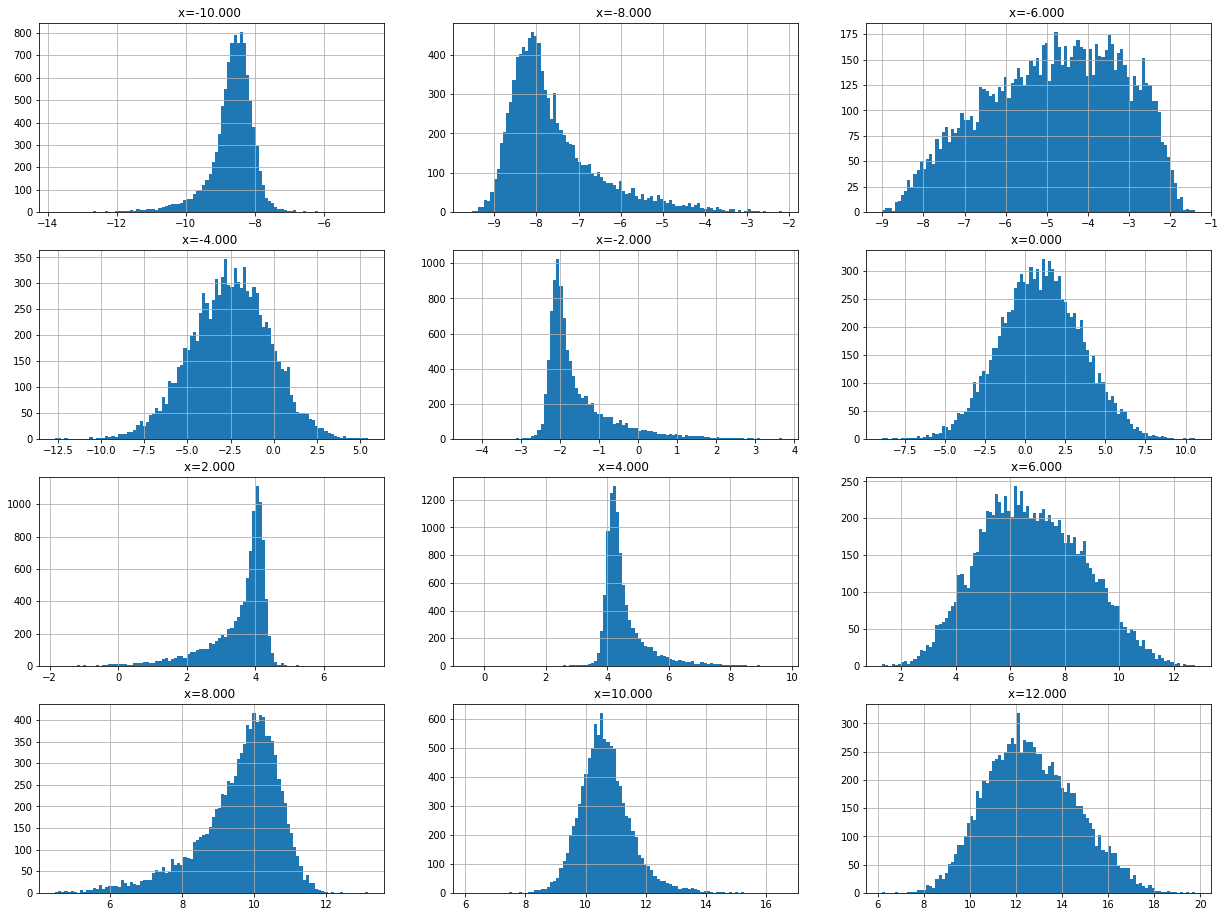













  0%|          | 0/100 [00:00<?, ?it/s]











100%|██████████| 100/100 [00:00<00:00, 1797.99it/s]

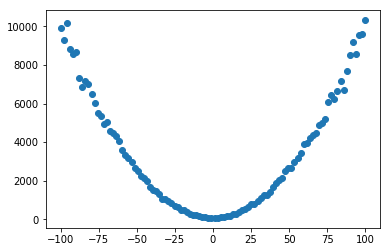













  0%|          | 0/100 [00:00<?, ?it/s]











100%|██████████| 100/100 [00:00<00:00, 1985.97it/s]

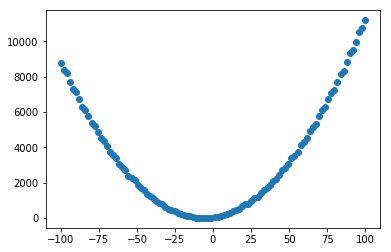

In [158]:
%run -i model.ipynb

## Recovering conditional density with RealNVP

http://akosiorek.github.io/ml/2018/04/03/norm_flows.html

$p(y, \mu) = p(y | \mu) p(\mu)$

$p(\mu) = \delta(\mu - \mu_0)$

In [159]:
device = torch.device('cuda:0')

In [160]:
from torch import nn
from itertools import chain

class RealNVP(nn.Module):
    def __init__(self, nets, nett, masks, prior):
        super(RealNVP, self).__init__()
        self.prior = prior
        self.masks = nn.Parameter(masks, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in reversed(range(len(self.masks))):
            x = self.masks[i] * x + \
              (1 - self.masks[i]) * ((1 - self.masks[i]) * x - self.t[i](self.masks[i] * x)) * (-self.s[i](self.masks[i] * x)).exp()
        return x

    def f(self, x):
        log_det_J = []
        for i in range(len(self.masks)):
            x = self.masks[i] * x + \
               (1 - self.masks[i]) * (x * (self.s[i](self.masks[i] * x)).exp() + self.t[i](self.masks[i] * x))
            log_det_J.append(((1 - self.masks[i]) * self.s[i](self.masks[i] * x)).sum(dim=1))

        return x, sum(log_det_J)
    
    def log_prob(self, x):
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        return logp
        
    def sample(self, batchSize): 
        z = self.prior.sample(batchSize)
        x = self.g(z)
        return x

In [161]:
NUM_NEURONS = 256
NUM_LAYERS = 1
NUM_COUPLIN = 10

In [162]:
nets = lambda: nn.Sequential(*
                             [nn.Linear(dimX, NUM_NEURONS), nn.LeakyReLU()] + 
                             list(chain.from_iterable([[nn.Linear(NUM_NEURONS, NUM_NEURONS), nn.LeakyReLU()] for _ in range(NUM_LAYERS)])) + 
                             [nn.Linear(NUM_NEURONS, dimX)]
                            )
nett = lambda: nn.Sequential(*
                             [nn.Linear(dimX, NUM_NEURONS), nn.Tanh()] + 
                             list(chain.from_iterable([[nn.Linear(NUM_NEURONS, NUM_NEURONS), nn.LeakyReLU()] for _ in range(NUM_LAYERS)])) + 
                             [nn.Linear(NUM_NEURONS, dimX)]
                            )

In [164]:
dimX = 3

masks = []
for i in range(NUM_COUPLIN):
    masks.append(torch.fmod(torch.arange(dimX - 1, -1, -1, dtype=torch.float32) + i, 2))
masks = torch.stack(masks, dim=0).to(device)

In [195]:
class CondPrior:
    def __init__(self, y_sampler):
        self.y_sampler = y_sampler
        self.independent = dist.Normal(loc=torch.tensor(0.).to(device), scale=torch.tensor(1.).to(device))
        
    def log_prob(self, x):
        mu = pyro.sample('mu', self.y_sampler.mu_dist)
        X = pyro.sample('X', self.y_sampler.x_dist)
        mu_dist_approx = dist.Normal(loc=mu.to(device), scale=torch.tensor(0.01).to(device))
        # x_dist_approx = dist.Normal(loc=X.to(device), scale=torch.tensor(0.01).to(device))
        print(y_sampler.x_dist.log_prob(x[:, 2].cpu()))
        log_prob = self.independent.log_prob(x[:, 0]) + mu_dist_approx.log_prob(x[:, 1]) + x_dist_approx.log_prob(x[:, 2])
        return log_prob
    
    def sample(self, batchSize):
        z = torch.stack([self.independent.sample([batchSize]), 
                         pyro.sample('mu', self.y_sampler.mu_dist).to(device),
                         pyro.sample('X', self.y_sampler.x_dist).to(device)]).t()
        return z

In [196]:
prior = CondPrior(y_sampler)

In [197]:
flow = RealNVP(nets, nett, masks, prior).to(device)

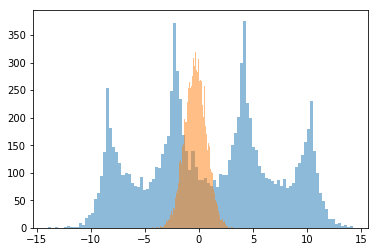

In [198]:
with pyro.condition(data={"X": dist.Uniform(-10, 10).sample([10000]), 
                          "mu": torch.tensor(0.).repeat(10000).detach()}):
    samples = y_sampler.sample()
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

with pyro.condition(data={"X": dist.Uniform(-10, 10).sample([10000]), 
                          "mu": torch.tensor(0.).repeat(10000).detach()}):
    samples = flow.sample(10000)[:, 0]
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

In [199]:
def reg_foo(parameters): 
    return sum([param.norm() for param in parameters])

In [200]:
mus = torch.tensor(0.).repeat(10000) #.to(device)
Xs = dist.Uniform(-10, 10).sample([10000])

with pyro.condition(data={"mu": mus, 'X': Xs}):
    samples = y_sampler.sample()
    data = torch.stack([samples, mus, Xs]).detach().t().to(device)

In [201]:
with pyro.condition(data={"mu": mus, 'X': Xs}):
    flow.log_prob(data)

tensor([-2.9957, -2.9957, -2.9957,  ..., -2.9957, -2.9957, -2.9957])


NameError: name 'x_dist_approx' is not defined

iter 140: loss = -23.127


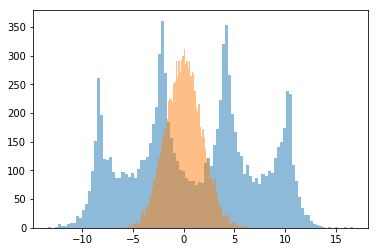

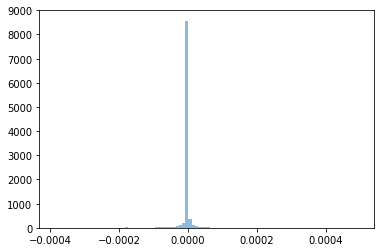

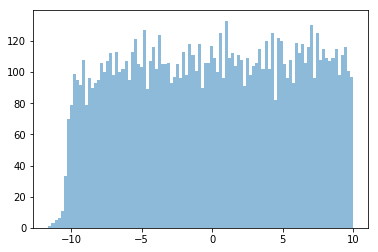

KeyboardInterrupt: 

In [177]:
from sklearn import datasets

from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(flow.parameters()) # list of all trainable parameters in a flow
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-5)# choose an optimizer, use module torch.optim

for t in tqdm(range(1000)):
    # on each iteration different \mu
    # new_mu = ((torch.rand(1) - 0.5) * 100)[0].to(device)
    # flow.prior.loc=torch.stack([torch.tensor(0.), new_mu]).to(device)
    # conditioned_y_sample = poutine.condition(y_sample, data={"mu": new_mu})
    with pyro.condition(data={"mu": mus, 'X': Xs}):
        flow_loss = -flow.log_prob(data).mean()
    
    loss = flow_loss + 1e-6 * reg_foo(trainable_parametrs) # compute the maximum-likelihood loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    if t % 20 == 0:
        clear_output()
        
        print('iter %s:' % t, 'loss = %.3f' % flow_loss)
        plt.figure()
        with pyro.condition(data={"mu": mus, 'X': Xs}):
            samples = y_sampler.sample()
        plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

        with pyro.condition(data={"mu": mus, 'X': Xs}):
            samples = flow.sample(10000)
        plt.hist(samples[:, 0].detach().cpu().numpy(), bins=100, alpha=0.5);
        plt.show()
        
        plt.figure()
        plt.hist(samples[:, 1].detach().cpu().numpy(), bins=100, alpha=0.5);
        plt.show()
        
        plt.figure()
        plt.hist(samples[:, 2].detach().cpu().numpy(), bins=100, alpha=0.5);
        plt.show()

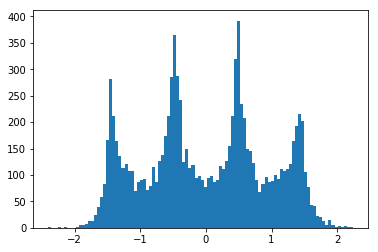

In [77]:
plt.hist(flow.f(data)[0][:, 0].detach().cpu().numpy(), bins=100);

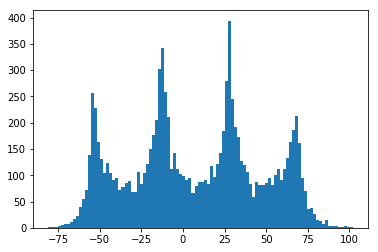

In [78]:
plt.hist(flow.g(data)[:, 0].detach().cpu().numpy(), bins=100);

## Compare distrs

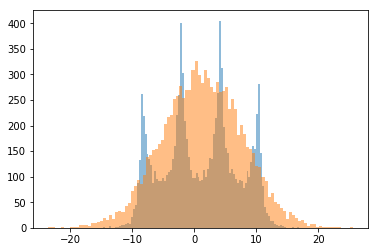

In [31]:
mus = torch.tensor(0.).repeat(10000)

with pyro.condition(data={"mu": mus}):
    samples = y_sampler.sample()
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

with pyro.condition(data={"mu": mus}):
    samples = flow.sample(10000)[:, 0]
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

## Conditioned

In [15]:
mu_range=(-5, 5)

In [16]:
mus = ((mu_range[0] - mu_range[1]) * (torch.rand(100000)) + mu_range[1]).to(device)
with pyro.condition(data={"mu": mus}):
    samples = y_sample().detach().to(device)

In [17]:
data = torch.stack([samples.to(device), mus]).detach().t()

In [18]:
from sklearn import datasets
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(flow.parameters()) # list of all trainable parameters in a flow
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)# choose an optimizer, use module torch.optim


for t in tqdm(range(5000)):
    # on each iteration different \mu
    with pyro.condition(data={"mu": mus}):
        flow_loss = -flow.log_prob(data).mean()
    
    loss = flow_loss + 1e-4 * reg_foo(trainable_parametrs) # compute the maximum-likelihood loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % flow_loss)

iter 0: loss = 1628.967
iter 200: loss = 2.147
iter 400: loss = -0.171
iter 600: loss = -1.189
iter 800: loss = -1.614
iter 1000: loss = -1.794
iter 1200: loss = -1.875
iter 1400: loss = -1.916
iter 1600: loss = -1.941
iter 1800: loss = -1.959
iter 2000: loss = -1.974
iter 2200: loss = -1.986
iter 2400: loss = -1.996
iter 2600: loss = -2.005
iter 2800: loss = -2.013
iter 3000: loss = -2.019
iter 3200: loss = -2.024
iter 3400: loss = -2.029
iter 3600: loss = -2.033
iter 3800: loss = -2.037
iter 4000: loss = -2.040
iter 4200: loss = -2.042
iter 4400: loss = -2.044
iter 4600: loss = -2.046
iter 4800: loss = -2.047



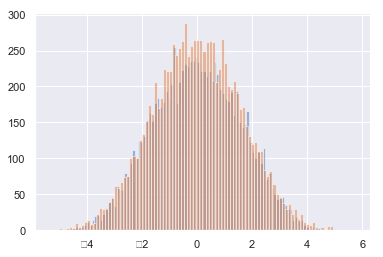

In [19]:
mus = ((mu_range[0] - mu_range[1]) * (torch.rand(10000)) + mu_range[1]).to(device)

with pyro.condition(data={"mu": mus}):
    samples = y_sample()
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

with pyro.condition(data={"mu": mus}):
    samples = flow.sample(10000)[:, 0]
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

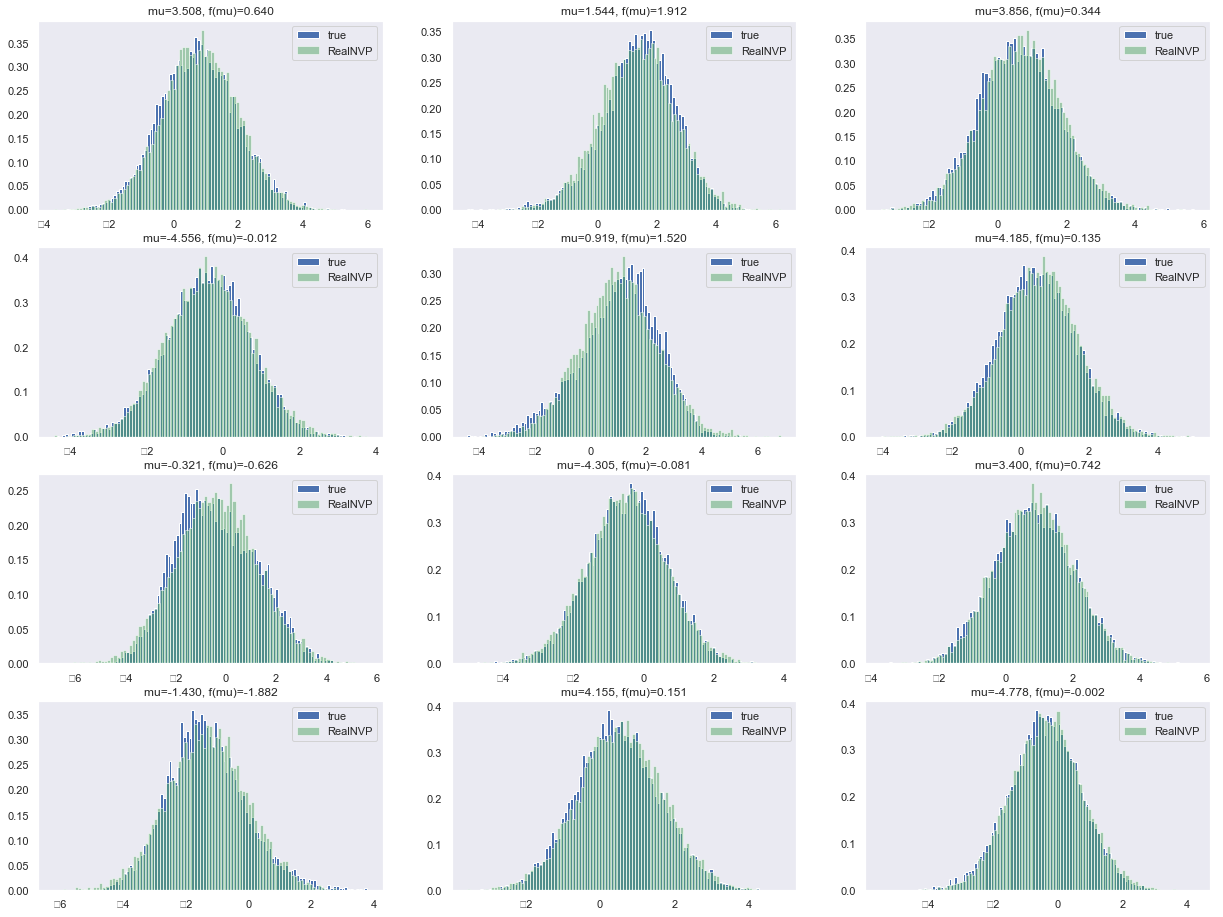

In [20]:
plt.figure(figsize=(21, 16))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        mus = torch.stack(10000 * [-10 * torch.rand(1) + 5]).view(-1).to(device)

       
        with pyro.condition(data={"mu": mus}):
            samples = y_sample().detach().to(device)  
        plt.hist(samples.detach().cpu().numpy(), bins=100, density=True, label='true');
        
        with pyro.condition(data={"mu": mus}):
            samples = flow.sample(10000)[:, 0]
        plt.hist(samples.detach().cpu().numpy(), 
                 bins=100, color='g', density=True, alpha=0.5, label='RealNVP');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}, f(mu)={:.3f}".format(mus[0].item(), f(mus[0]).item()))

Text(0.5, 1.0, 'mu=15.000, f(mu)=1.650')

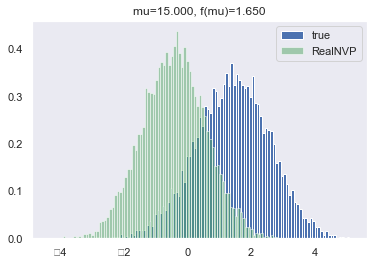

In [21]:
mus = torch.full(size=(10000, ), fill_value=15.).to(device)

with pyro.condition(data={"mu": mus}):
    samples = y_sample().detach().to(device)  
plt.hist(samples.detach().cpu().numpy(), bins=100, density=True, label='true');

with pyro.condition(data={"mu": mus}):
    samples = flow.sample(10000)[:, 0]
plt.hist(samples.detach().cpu().numpy(), 
         bins=100, color='g', density=True, alpha=0.5, label='RealNVP');
plt.grid()
plt.legend()
plt.title("mu={:.3f}, f(mu)={:.3f}".format(mus[0].item(), f(mus[0]).item()))

In [28]:
mus = torch.tensor(5.).repeat(1000).to(device)
mus.requires_grad = True

In [29]:
%%time
n_iter = 10000
lr = 1e-1

losses = []
m_vals = []
for _iter in tqdm(range(n_iter)):
    with pyro.condition(data={"mu": mus}):
        data = flow.sample(1000)[:, 0]

    loss = R(data)
    losses.append(loss.item())
    # if not mus.grad is None: mus.grad.zero_()
        
    loss.backward()
    with torch.no_grad():
        mus.data -= lr * mus.grad.mean()
        mus.grad.zero_()
    
    m_vals.append(mus[0].item())
    
    if _iter % 500 == 0:
        print(losses[-1], m_vals[-1])

28.3041934967041 5.000310897827148
27.589094161987305 5.151706695556641
27.61228370666504 5.292297840118408
27.34440803527832 5.423404216766357
27.48154067993164 5.546217918395996
27.34304428100586 5.661787986755371
26.939281463623047 5.770840167999268
26.091032028198242 5.874263763427734
26.48006248474121 5.972487449645996
25.57277488708496 6.066009521484375
25.97597312927246 6.155395984649658
26.174026489257812 6.240862846374512
25.36820411682129 6.32288122177124
24.981060028076172 6.401721954345703
25.42432975769043 6.477683067321777
26.25340461730957 6.550891876220703
25.729084014892578 6.621628284454346
25.040687561035156 6.689988613128662
24.79808235168457 6.756187915802002
25.49847412109375 6.820448875427246

CPU times: user 2min 5s, sys: 4.2 s, total: 2min 9s
Wall time: 2min 12s


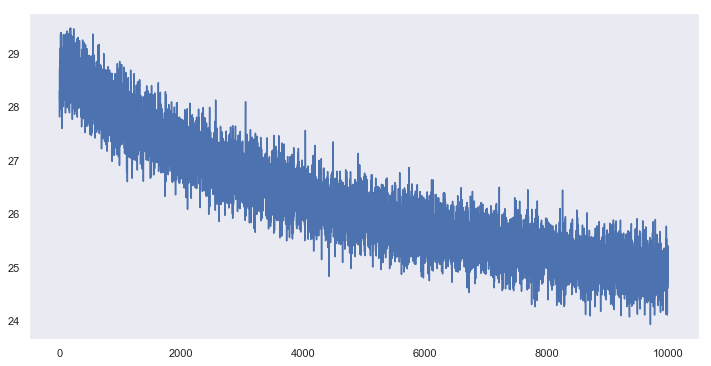

In [30]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()

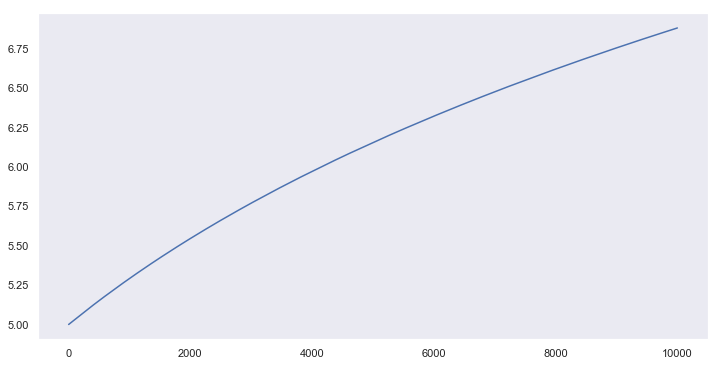

In [31]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()

In [27]:
m_vals[-1]

-1.8527159690856934